In [1]:
import numpy as np
import pandas as pd

import imageio
import imagesc
import cellpose

import glob
import re

import torch

import matplotlib.pyplot as plt
import seaborn as sns

import skimage
import skimage.io
from skimage.io import imsave
from skimage.measure import label, regionprops_table, regionprops

from aicsimageio.readers import CziReader
from cellpose import utils, io, models, plot

import cv2 as cv
from typing import List

In [3]:
Image = np.ndarray

def laplacian_variance(img: Image) -> float:
    return np.var(cv.Laplacian(img, cv.CV_64F, ksize=21))


def find_best_z_plane_id(img_list: List[Image]) -> int:
    lap_vars_per_z_plane = []
    for img in img_list:
        lap_vars_per_z_plane.append(laplacian_variance(img))
    max_var = max(lap_vars_per_z_plane)
    max_var_id = lap_vars_per_z_plane.index(max_var)
    return max_var_id

In [23]:
file_paths = sorted(glob.glob('/Users/haokai/Desktop/Github repository/Demo/Ratiometric_barcode_readout/Raw data_demo/**/*).czi', recursive = True))
save_path = '/Users/haokai/Desktop/Github repository/Demo/Ratiometric_barcode_readout/SmartMax_demo/'

In [24]:
file_paths

['/Users/haokai/Desktop/Github repository/Demo/Ratiometric_barcode_readout/Raw data_demo/pAA15_D10(pKH012)_pKH004_dWntR21_5(1).czi',
 '/Users/haokai/Desktop/Github repository/Demo/Ratiometric_barcode_readout/Raw data_demo/pAA15_D10(pKH012)_pKH004_dWntR21_5(2).czi',
 '/Users/haokai/Desktop/Github repository/Demo/Ratiometric_barcode_readout/Raw data_demo/pAA15_D10(pKH012)_pKH004_dWntR21_5(3).czi']

# Maximum intensity projection applyed for czi file

In [21]:
thresh = 20 # threshold to reject out of focus frames
ch = 2 # channel to use (DAPI by default)

for f in file_paths:
    reader = CziReader(f)
    num_channels = np.shape(reader.data)[0]
    stack_size = np.shape(reader.data)[1]
    
    lv_list = []
    for s in range(stack_size):
        lv_list.append(laplacian_variance(reader.data[ch,s,:,:]))
    lv = np.array(lv_list)
    lv_norm = 100*(lv - np.min(lv))/(np.max(lv) - np.min(lv))
    lv_arr = np.concatenate((np.array([False]), lv_norm>thresh, np.array([False])))
    stretch = np.where(np.diff(lv_arr) == True)[0]
    max_stretch_index = np.argmax([stretch[i+1] - stretch[i] for i in range(0,len(stretch),2)])
    start = stretch[max_stretch_index*2]
    end = stretch[max_stretch_index*2 + 1]
    
    for c in range(num_channels):
        img = np.max(reader.data[c,start:end,:,:], axis=0)
        imsave(save_path + re.split('/', f)[-1][:-4] + '_ch' + str(c+1) + '.tif' , img, check_contrast=False)

In [22]:
thresh = 20 # threshold to reject out of focus frames
ch = 2 # channel to use (DAPI by default)

start_list = []
end_list = []
name_list = []
for f in file_paths:
    reader = CziReader(f)
    num_channels = np.shape(reader.data)[0]
    stack_size = np.shape(reader.data)[1]
    
    lv_list = []
    for s in range(stack_size):
        lv_list.append(laplacian_variance(reader.data[ch,s,:,:]))
    lv = np.array(lv_list)
    lv_norm = 100*(lv - np.min(lv))/(np.max(lv) - np.min(lv))
    lv_arr = np.concatenate((np.array([False]), lv_norm>thresh, np.array([False])))
    stretch = np.where(np.diff(lv_arr) == True)[0]
    max_stretch_index = np.argmax([stretch[i+1] - stretch[i] for i in range(0,len(stretch),2)])
    start = stretch[max_stretch_index*2]
    end = stretch[max_stretch_index*2 + 1]
    
    start_list.append(start)
    end_list.append(end)
    name_list.append(re.split('/', f)[-1][:-4])
    
df = pd.DataFrame(list(zip(name_list,start_list,end_list)), columns=['name','start','end'])
df

,name,start,end
0,pAA15_D10(pKH012)_pKH004_dWntR21_5(1),2,18
1,pAA15_D10(pKH012)_pKH004_dWntR21_5(2),4,21
2,pAA15_D10(pKH012)_pKH004_dWntR21_5(3),3,17


# ‘cyto’ model of CellPose for nuclei segementation

In [26]:
data_dir = '/Users/haokai/Desktop/Github repository/Demo/Ratiometric_barcode_readout/'

In [28]:
files = sorted(glob.glob(data_dir + 'SmartMax_demo/*_ch4.tif'))
files

['/Users/haokai/Desktop/Github repository/Demo/Ratiometric_barcode_readout/SmartMax_demo/pAA15_D10(pKH012)_pKH004_dWntR21_5(1)_ch4.tif',
 '/Users/haokai/Desktop/Github repository/Demo/Ratiometric_barcode_readout/SmartMax_demo/pAA15_D10(pKH012)_pKH004_dWntR21_5(2)_ch4.tif',
 '/Users/haokai/Desktop/Github repository/Demo/Ratiometric_barcode_readout/SmartMax_demo/pAA15_D10(pKH012)_pKH004_dWntR21_5(3)_ch4.tif']

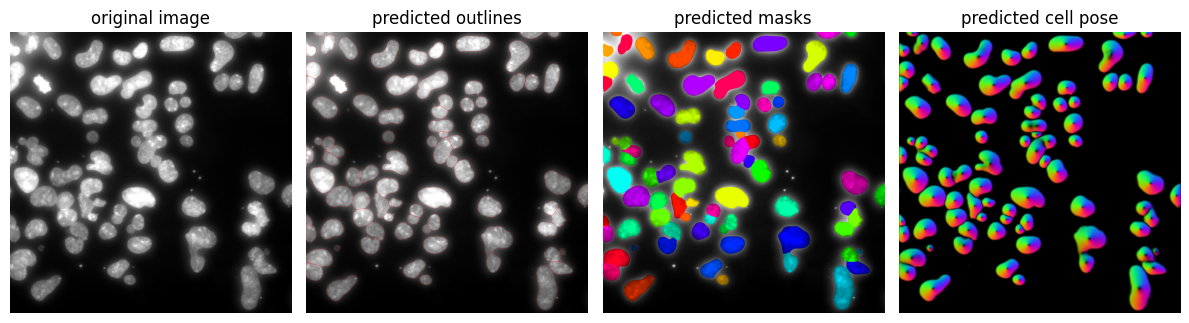

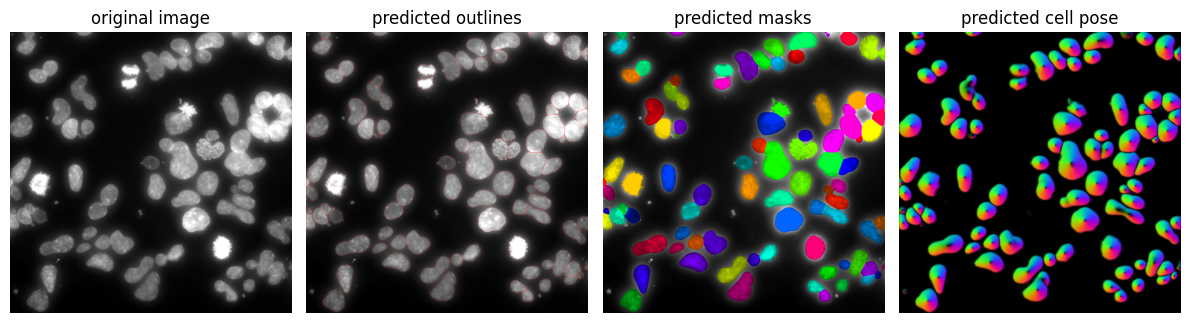

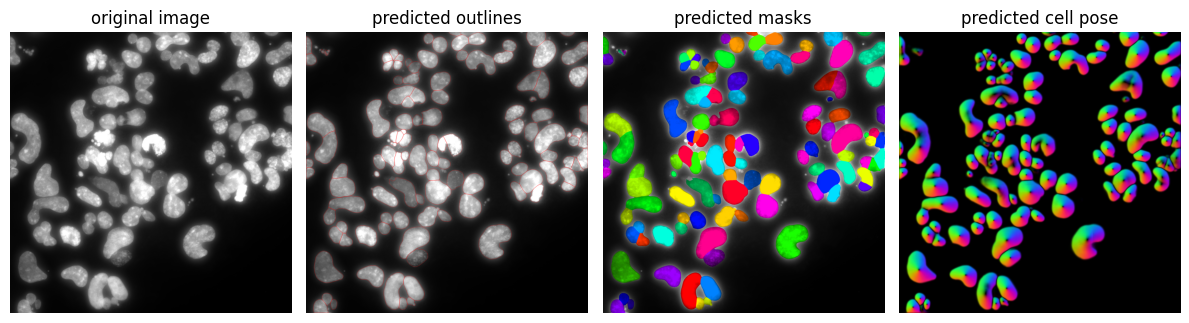

In [35]:
# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=True, model_type='cyto')

files = sorted(glob.glob(data_dir + 'SmartMax_demo/*_ch4.tif'))

# define CHANNELS to run segementation on, each element in the channels list represents a pair of values [cell_channel, nucleus_channel]
channels = [[0,0]]*len(files)

for chan, filename in zip(channels, files):
    img = skimage.io.imread(filename)
    masks, flows, styles, diams = model.eval(img, diameter=90, resample=True, channels=chan, flow_threshold=0.9)

    # save results so you can load in gui
    io.masks_flows_to_seg(img, masks, flows, diams, filename, chan)

    # save results as png
    io.save_to_png(img, masks, flows, filename)
    
    # DISPLAY RESULTS
    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
    plt.tight_layout()
    plt.show()

When you set resample to True, Cellpose performs resampling. It typically involves rescaling or resizing the input image to a different resolution. This can be useful in cases where you want to segment objects in the image at a different scale or resolution than the original image. Resampling can be useful when you need to segment objects of different sizes in an image.